# Crypto Altcoin Price Prediction with Multivariate Time Series
## (A Comparison of Twitter Sentiment & Blockchain Activity Data)

In my thesis, I extracted 1 year of data from two different data sources (Twitter sentiment analysis & blockchain activity data provided by Santiment) to predict the price of 3 altcoins (OmiseGo, Enjin & Chainlink) with Vector Autoregression (VAR) - a multivariate time series forecasting model.

Price predictions were carried out for 11 periods over a time frame of 7 days each.

I used the average of the following error metrics (over 11 periods) to evaluate the forecasts:
- MAPE (mean absolute percentage error)
- nRMSE (normalized root mean squared error)

In [2]:
from TwitterAltcoinData import TwitterAltcoinData as TAD
from SantimentAltcoinData import SantimentAltcoinData as SAD
from AltcoinPredictor import AltcoinPredictor
import util

import pandas as pd
import numpy as np

The first 4 imports are separate Python classes I wrote to make my work more efficient:

**TwitterAltcoinData** is created to:
- set parameters for the Twitter API calls
- to retrieve the attributes needed for my work
- and to write the extracted Tweets into a file locally

**SantimentAltcoinData** is used to:
- set project (altcoin), start & end date for which data should be retrieved
- to retrieve single time series for a list of metrics passed as parameter, and concatenate them into a dataframe
- to concatenate the altcoin price to the features dataframe

**AltcoinPredictor** is used to:
- initialize an object with a ready to use multivariate time series (e.g. the dataframe built with SantimentAltcoinData)
- split the dataframe into a training set & validation set based on a "cnt_valid" parameter (number of units to be used for validation set)
- fit + predict a VAR (Vector Autoregression) model of order 1
- save prediction output and error metrics (MAPE & nRMSE) in attributes
- print error metrics of the prediction after fit + predict
- plot prediction vs. real price

**util** is a utility class that contains several functions, to avoid repeating codes
***

As a first step, I read a text file where I stored all Tweets with the hashtag #chainlink in a JSON format, convert it to a dataframe & add some sentiment ranges as columns.

The output below shows 1 row (all features) of the dataframe:

In [3]:
c_tweets = util.read_txt_json('data/chainlink_all_sentiment_1y_v2.txt')
c_tweets_data = util.tweets_to_dataframe(c_tweets)
c_tweets_data = util.add_adjusted_sentiment_ranges(c_tweets_data)
c_tweets_data.iloc[0]

created_at                          Sun Mar 31 23:41:51 +0000 2019
lang                                                            en
sentiment_score                                                  0
sentiment_magnitude                                            0.1
favorite_count                                                  26
retweet_count                                                    9
user_followers_cnt                                            3665
cnt_hashtags                                                     0
cnt_symbols                                                      0
date                                           2019-03-31 00:00:00
followers_multiplier_base100                               2.56407
adj100_sentiment_score                                           0
adj100_sentiment_magnitude                                0.256407
adj100_sentiment_score_range                   sco_greater_neg_0.3
adj100_sentiment_magnitude_range                   mag_less_eq

## The Baseline Dataset (mean of sentiment score & magnitude and number of Tweets )
I'm grouping all Tweets by date and compute the mean of sentiment score & magnitude. I also want the number of Tweets as a feature, so I count the rows. priceBtc and priceUsd are the variables we want to predict.

The output is a time series ready to be passed through the VAR model.

In [4]:
c_tweets_df = c_tweets_data.groupby('date').agg({'sentiment_score': ['mean', 'count'],
                                            'sentiment_magnitude': ['mean']})
c_tweets_price_df = util.concat_price_to_project_metrics(c_tweets_df, project='chainlink')
c_tweets_price_df.index = pd.DatetimeIndex(c_tweets_price_df.index.values,
                               freq=c_tweets_price_df.index.inferred_freq)
c_tweets_price_df.head()

,"(sentiment_score, mean)","(sentiment_score, count)","(sentiment_magnitude, mean)",priceBtc,priceUsd
2019-01-01,0.163158,19,0.468421,0.000078,0.299371
2019-01-02,0.057143,14,0.471429,0.000080,0.316489
2019-01-03,0.360377,53,0.581132,0.000096,0.366445
2019-01-04,0.385000,120,0.561667,0.000113,0.437175
2019-01-05,0.393846,65,0.556923,0.000103,0.395948


Next I apply a utility function I wrote, which takes 3 parameters (a dataframe, a list of prediction end dates and a predictor aka. my "AltcoinPredictor" class object).

Here is what the "predict_multi_periods" function does:
- For each of 'pred_dates', it creates an AltcoinPredictor with the above dataframe till the according end date,
- splits the dataframe into a training & validation set, where the 7 days of the dataframe is the validation set,
- fit + predicts using VAR of order 1 and saves all error metrics and price predictions in a dictionary
- and returns 2 dicts (error metrics & price predictions for each period)

In [5]:
pred_dates = ['2019-11-07', '2019-11-14', '2019-11-21', '2019-11-28',
            '2019-12-05', '2019-12-12', '2019-12-19', '2019-12-26',
            '2020-01-02', '2020-01-09', '2020-01-16']

c1_pred, c1_plots = util.predict_multi_periods(df=c_tweets_price_df, dates=pred_dates, predictor=AltcoinPredictor)

In [6]:
c1_pred.keys(), c1_pred['MAPE USD']

(dict_keys(['nRMSE USD', 'MAPE USD', 'nRMSE BTC', 'MAPE BTC', 'USD Movement correct', 'BTC Movement correct']),
 [0.757, 6.64, 8.966, 8.556, 4.459, 6.474, 7.542, 5.24, 2.064, 12.821, 5.474])

Convert the error metrics dict to a dataframe (prediction period as index) and print it:

In [7]:
c1_pred_df = pd.DataFrame(c1_pred, index=pred_dates)
c1_pred_df

,nRMSE USD,MAPE USD,nRMSE BTC,MAPE BTC,USD Movement correct,BTC Movement correct
2019-11-07,0.009,0.757,0.013,1.151,True,True
2019-11-14,0.083,6.640,0.135,12.000,False,False
2019-11-21,0.104,8.966,0.020,1.937,False,True
2019-11-28,0.088,8.556,0.035,2.890,True,True
2019-12-05,0.049,4.459,0.031,2.558,True,True
2019-12-12,0.077,6.474,0.096,7.349,False,False
2019-12-19,0.090,7.542,0.057,4.703,True,True
2019-12-26,0.055,5.240,0.043,4.112,False,False
2020-01-02,0.024,2.064,0.010,0.794,True,True
2020-01-09,0.161,12.821,0.073,4.791,False,False


Let's do all the same steps for OmiseGo (Tweets with #omisego) and Enjin (#enjin), so we have an overview.

The code is a repetition of the steps above. So, I will hide it.

The evaluation metrics for OmiseGo & Enjin will be saved in variable "o1_pred" & "e1_pred".

In [8]:
# OmiseGo (to-do: write a function for this or hide it)
o_tweets = util.read_txt_json('data/omisego_all_sentiment_1y_v2.txt')
o_tweets_data = util.tweets_to_dataframe(o_tweets)
o_tweets_data = util.add_adjusted_sentiment_ranges(o_tweets_data)
o_tweets_df = o_tweets_data.groupby('date').agg({'sentiment_score': ['mean', 'count'],
                                           'sentiment_magnitude': ['mean']})
o_tweets_price_df = util.concat_price_to_project_metrics(o_tweets_df, project='omisego')
o_tweets_price_df.index = pd.DatetimeIndex(o_tweets_price_df.index.values,
                               freq=o_tweets_price_df.index.inferred_freq)
o1_pred, o1_plots = util.predict_multi_periods(o_tweets_price_df, pred_dates, AltcoinPredictor)

# Enjin
e_tweets = util.read_txt_json('data/enjin_all_sentiment_1y_v2.txt')
e_tweets_data = util.tweets_to_dataframe(e_tweets)
e_tweets_data = util.add_adjusted_sentiment_ranges(e_tweets_data)
e_tweets_df = e_tweets_data.groupby('date').agg({'sentiment_score': ['mean', 'count'],
                                          'sentiment_magnitude': ['mean']})
e_tweets_price_df = util.concat_price_to_project_metrics(e_tweets_df, project='enjin-coin')
e_tweets_price_df.index = pd.DatetimeIndex(e_tweets_price_df.index.values,
                              freq=e_tweets_price_df.index.inferred_freq)
e1_pred, e1_plots = util.predict_multi_periods(e_tweets_price_df, pred_dates, AltcoinPredictor)

An overview of the average evaluation metrics for all 3 altcoins:

In [9]:
# Baseline Evaluation Metrics
o1_pred_df = pd.DataFrame(o1_pred, index=pred_dates)
e1_pred_df = pd.DataFrame(e1_pred, index=pred_dates)
#c1_pred_df = pd.DataFrame(c1_pred, index=pred_dates)
baseline_eval = pd.DataFrame([o1_pred_df.mean(), e1_pred_df.mean(), c1_pred_df.mean()],
                        index=['OmiseGo', 'Enjin', 'Chainlink']).T
baseline_eval

,OmiseGo,Enjin,Chainlink
nRMSE USD,0.073909,0.078636,0.074000
MAPE USD,6.420364,6.817273,6.272091
nRMSE BTC,0.056273,0.100909,0.048818
MAPE BTC,4.819636,9.030273,4.015091
USD Movement correct,0.363636,0.363636,0.454545
BTC Movement correct,0.363636,0.636364,0.545455


Let's plot the MAPE of the altcoin's USD price prediction:

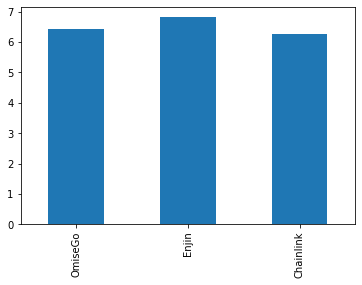

In [10]:
baseline_eval.loc['MAPE USD'].plot(kind='bar')

The following utility function takes a list of dataframes containing the altcoin's USD prediction & real price, then plots them one by one in a subplot.

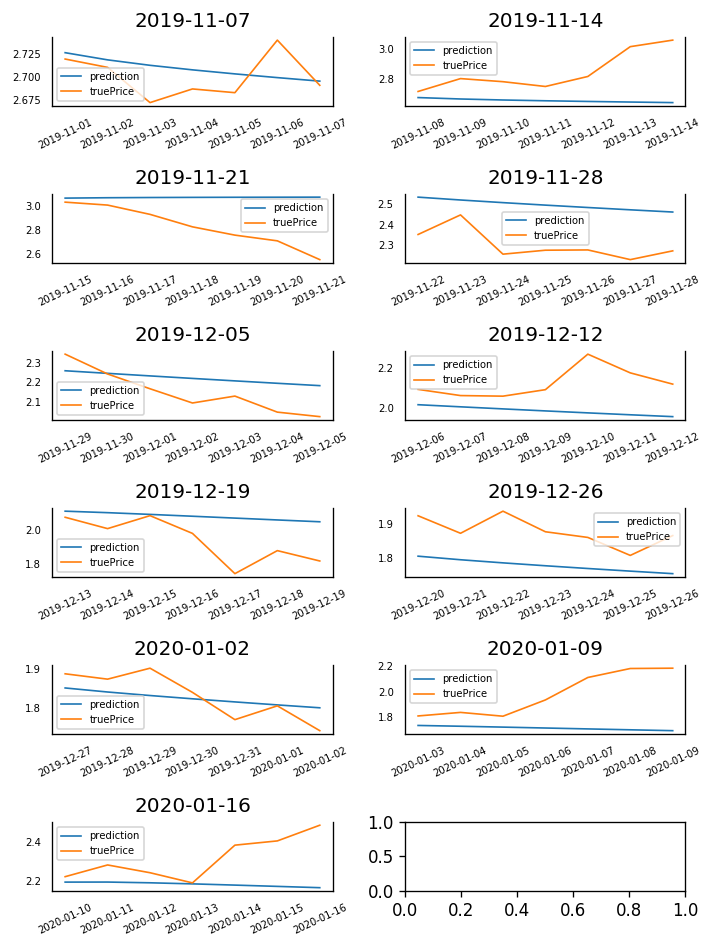

In [11]:
util.plot_predictions(c1_plots['USD pred'], pred_dates)

## Tweets Feature Engineering #1 (Sentiment Ranges)
The first ideas to feature engineering is to enhance the dataset with sentiment ranges as columns (=features). To achieve this, a thorough look at the frequency distribution of sentiment score & magnitude is sufficient.

The sentiment score of most Tweets are mostly centered around 0.0. The most interesting fact is that very few Tweets have a negative sentiment score. Most Tweets are neutral or slightly positive.

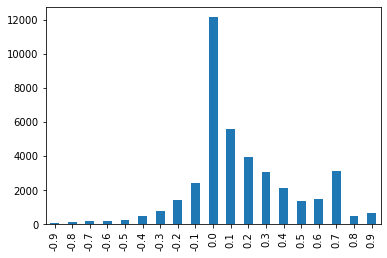

In [12]:
sentiment_score_counts = c_tweets_data.sentiment_score.value_counts().sort_index()
sentiment_score_counts.plot(kind='bar')

The magnitude indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf.

A high number of Tweets fall into the 0.0 <= x <= 0.3 range. Tweets with a higher than 1.0 magnitude happen occasionally, whereas Tweets with x >= 1.5 can be considered outliers. I use these insights to create baskets of sentiment scores in which Tweets are categorized into.

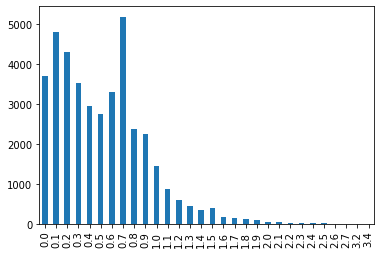

In [13]:
sentiment_magnitude_counts = c_tweets_data.sentiment_magnitude.value_counts().sort_index()
sentiment_magnitude_counts.plot(kind='bar')

Using the insights about the frequency distribution of the sentiment scores and magnitudes, I came up with the following sentiment ranges.

Features for sentiment score ranges:
- x <= -0.3
- -0.3 < x <= 0
- 0 < x <= 0.2
- 0.2 < x <= 0.5
- 0.5 < x <= 0.7
- x > 0.7
- Sentiment score mean & count (which gives us the # of Tweets)

Features for sentiment magnitude ranges:
- x <= 0.3
- 0.3 < x <= 0.6
- 0.6 < x <= 0.8
- x > 0.8
- Sentiment magnitude mean

So, create a dictionary of the columns we want to aggregate on as **key** & a list of functions to apply on the column as **value**:

In [14]:
sentiment_agg = {'sentiment_score': [
                    ('less_eq_neg_0.3', lambda x: x.le(-0.3).mean()),
                    ('greater_neg_0.3', lambda x: (x.gt(-0.3) & x.le(0)).mean()),
                    ('greater_0', lambda x: (x.gt(0) & x.le(0.2)).mean()),
                    ('greater_0.2', lambda x: (x.gt(0.2) & x.le(0.5)).mean()),
                    ('greater_0.5', lambda x: (x.gt(0.5) & x.le(0.7)).mean()),
                    ('greater_0.7', lambda x: x.gt(0.7).mean()),
                    ('mean', 'mean'),
                    ('count', 'count')
                ],
                'sentiment_magnitude': [
                    ('less_eq_0.3', lambda x: x.le(0.3).mean()),
                    ('greater_0.3', lambda x: (x.gt(0.3) & x.le(0.6)).mean()),
                    ('greater_0.6', lambda x: (x.gt(0.6) & x.le(0.8)).mean()),
                    ('greater_0.8', lambda x: x.gt(0.8).mean()),
                    ('mean', 'mean')
                ]}

Applying the aggregate function to the dataframe gives us a time series. Then, we concatenate the prices.
The output shows the first 5 rows of the dataframe that is ready for VAR.

### Explanation of the Values
The feature values in the dataframe are the percentages of the number of Tweets that fall into the sentiment range. The sum for all ”sentiment score” features (excluding the mean & count) equals to 1. The same goes for the sum of all ”sentiment magnitude” features.

E.g. the value (sentiment score, greater neg 0.3) = 0.421053 means that roughly 42% of the 19 Tweets on the 1st Jan 2019 had a sentiment score of -0.3 < x <= 0.

In [15]:
c2_data = c_tweets_data.groupby('date').agg(sentiment_agg)
c2_price_df = util.concat_price_to_project_metrics(c2_data, project='chainlink')
c2_price_df.index = pd.DatetimeIndex(c2_price_df.index.values,
                               freq=c2_price_df.index.inferred_freq)
c2_price_df.head()

,"(sentiment_score, less_eq_neg_0.3)","(sentiment_score, greater_neg_0.3)","(sentiment_score, greater_0)","(sentiment_score, greater_0.2)","(sentiment_score, greater_0.5)","(sentiment_score, greater_0.7)","(sentiment_score, mean)","(sentiment_score, count)","(sentiment_magnitude, less_eq_0.3)","(sentiment_magnitude, greater_0.3)","(sentiment_magnitude, greater_0.6)","(sentiment_magnitude, greater_0.8)","(sentiment_magnitude, mean)",priceBtc,priceUsd
2019-01-01,0.000000,0.421053,0.315789,0.105263,0.157895,0.000000,0.163158,19,0.526316,0.315789,0.052632,0.105263,0.468421,0.000078,0.299371
2019-01-02,0.071429,0.500000,0.142857,0.285714,0.000000,0.000000,0.057143,14,0.428571,0.214286,0.142857,0.214286,0.471429,0.000080,0.316489
2019-01-03,0.018868,0.301887,0.113208,0.094340,0.433962,0.037736,0.360377,53,0.283019,0.150943,0.415094,0.150943,0.581132,0.000096,0.366445
2019-01-04,0.041667,0.250000,0.083333,0.125000,0.458333,0.041667,0.385000,120,0.233333,0.258333,0.425000,0.083333,0.561667,0.000113,0.437175
2019-01-05,0.000000,0.338462,0.046154,0.046154,0.569231,0.000000,0.393846,65,0.230769,0.276923,0.461538,0.030769,0.556923,0.000103,0.395948


Apply the "predict_multi_periods" for this dataset, in order to get the error metrics and price preditions.

In [16]:
c2_pred, c2_plots = util.predict_multi_periods(c2_price_df, pred_dates, AltcoinPredictor)
c2_pred_df = pd.DataFrame(c2_pred, index=pred_dates)

Again, let's do all the same steps for OmiseGo and Enjin, so we have an overview.

The code is a repetition of the steps above. So, I will hide it.

The evaluation metrics for OmiseGo & Enjin will be saved in variable "o2_pred_df" & "e2_pred_df".

In [17]:
# OmiseGo
o2_data = o_tweets_data.groupby('date').agg(sentiment_agg)
o2_price_df = util.concat_price_to_project_metrics(o2_data, project='omisego')
o2_price_df.index = pd.DatetimeIndex(o2_price_df.index.values,
                                    freq=o2_price_df.index.inferred_freq)
o2_pred, o2_plots = util.predict_multi_periods(o2_price_df, pred_dates, AltcoinPredictor)
o2_pred_df = pd.DataFrame(o2_pred, index=pred_dates)

# Enjin
e2_data = e_tweets_data.groupby('date').agg(sentiment_agg)
e2_price_df = util.concat_price_to_project_metrics(e2_data, project='enjin-coin')
e2_price_df.index = pd.DatetimeIndex(e2_price_df.index.values,
                                     freq=e2_price_df.index.inferred_freq)
e2_pred, e2_plots = util.predict_multi_periods(e2_price_df, pred_dates, AltcoinPredictor)
e2_pred_df = pd.DataFrame(e2_pred, index=pred_dates)

### Evaluation Metrics (Sentiment Ranges vs. Baseline)

In [18]:
sentiment_ranges_eval = pd.DataFrame([o2_pred_df.mean(), e2_pred_df.mean(), c2_pred_df.mean()],
                                    index=['OmiseGo', 'Enjin', 'Chainlink']).T

comparison_sentiment_ranges_baseline = pd.concat([sentiment_ranges_eval, baseline_eval], axis=1,
                                    keys=['Sentiment Ranges', 'Baseline']).apply(lambda x: round(x, 3))

comparison_sentiment_ranges_baseline

Sentiment Ranges                  Baseline         \
                              OmiseGo  Enjin Chainlink  OmiseGo  Enjin   
nRMSE USD                       0.077  0.082     0.071    0.074  0.079   
MAPE USD                        6.556  7.292     5.948    6.420  6.817   
nRMSE BTC                       0.056  0.100     0.047    0.056  0.101   
MAPE BTC                        4.740  9.232     3.793    4.820  9.030   
USD Movement correct            0.455  0.545     0.545    0.364  0.364   
BTC Movement correct            0.364  0.727     0.545    0.364  0.636   

                                
                     Chainlink  
nRMSE USD                0.074  
MAPE USD                 6.272  
nRMSE BTC                0.049  
MAPE BTC                 4.015  
USD Movement correct     0.455  
BTC Movement correct     0.545

### Plot Evaluation (Sentiment Ranges vs. Baseline)
Here is a comparison of the MAPE of the altcoin's USD price prediction between the sentiment ranges approach & the baseline:

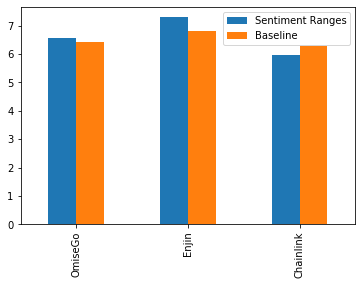

In [19]:
comparison_sentiment_ranges_baseline.loc['MAPE USD'].unstack(level=0).plot(kind='bar')

## Tweets Feature Engineering #2 (Combination of Sentiment Score & Magnitude Ranges)

A further improvisation of the sentiment ranges is to use the combination of sentiment score range & sentiment magnitude range. In other words, instead of knowing the # of Tweets with high sentiment score, the knowledge about # of Tweets with both high sentiment score and magnitude may lead to a better price prediction.

In [20]:
c3_data = pd.pivot_table(c_tweets_data, values='created_at',
                                        index='date', columns=['sentiment_magnitude_range', 'sentiment_score_range'],
                                        aggfunc=len, fill_value=0).astype(float)
c3_data = c3_data.div(c3_data.sum(1), axis=0)

c3_data = pd.concat([c3_data, c_tweets_df], axis=1)
c3_price_df = util.concat_price_to_project_metrics(c3_data, project='chainlink')
c3_price_df.index = pd.DatetimeIndex(c3_price_df.index.values,
                               freq=c3_price_df.index.inferred_freq)
c3_price_df.head()

,"(mag_greater_0.3, sco_greater_0)","(mag_greater_0.3, sco_greater_0.2)","(mag_greater_0.3, sco_greater_0.5)","(mag_greater_0.3, sco_greater_neg_0.3)","(mag_greater_0.3, sco_less_eq_neg_0.3)","(mag_greater_0.6, sco_greater_0)","(mag_greater_0.6, sco_greater_0.2)","(mag_greater_0.6, sco_greater_0.5)","(mag_greater_0.6, sco_greater_0.7)","(mag_greater_0.6, sco_greater_neg_0.3)",...,"(mag_greater_0.8, sco_less_eq_neg_0.3)","(mag_less_eq_0.3, sco_greater_0)","(mag_less_eq_0.3, sco_greater_0.2)","(mag_less_eq_0.3, sco_greater_neg_0.3)","(mag_less_eq_0.3, sco_less_eq_neg_0.3)","(sentiment_score, mean)","(sentiment_score, count)","(sentiment_magnitude, mean)",priceBtc,priceUsd
2019-01-01,0.105263,0.105263,0.105263,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.052632,...,0.000000,0.157895,0.000000,0.368421,0.000000,0.163158,19,0.468421,0.000078,0.299371
2019-01-02,0.071429,0.000000,0.000000,0.142857,0.000,0.000000,0.142857,0.000000,0.000,0.000000,...,0.071429,0.071429,0.071429,0.285714,0.000000,0.057143,14,0.471429,0.000080,0.316489
2019-01-03,0.000000,0.037736,0.075472,0.037736,0.000,0.037736,0.037736,0.339623,0.000,0.000000,...,0.018868,0.037736,0.000000,0.245283,0.000000,0.360377,53,0.581132,0.000096,0.366445
2019-01-04,0.033333,0.058333,0.100000,0.041667,0.025,0.008333,0.016667,0.358333,0.025,0.008333,...,0.000000,0.033333,0.008333,0.183333,0.008333,0.385000,120,0.561667,0.000113,0.437175
2019-01-05,0.030769,0.015385,0.138462,0.092308,0.000,0.000000,0.000000,0.430769,0.000,0.030769,...,0.000000,0.015385,0.000000,0.215385,0.000000,0.393846,65,0.556923,0.000103,0.395948


Fit + predict the above dataset for all 11 prediction periods, we see that the predictions failed completely due to so many features. The matrix is also fairly sparse for a multivariate time series.

In [21]:
c3_pred, c3_plots = util.predict_multi_periods(c3_price_df, pred_dates, AltcoinPredictor)
c3_pred_df = pd.DataFrame(c3_pred, index=pred_dates)
c3_pred_df.head()

,nRMSE USD,MAPE USD,nRMSE BTC,MAPE BTC,USD Movement correct,BTC Movement correct
2019-11-07,7.514582e+13,3.896050e+15,4.404970e+13,2.287261e+15,False,False
2019-11-14,7.454494e+13,3.094363e+15,2.468593e+14,1.026854e+16,True,False
2019-11-21,2.031840e+14,1.045984e+16,2.821149e+14,1.357563e+16,True,True
2019-11-28,1.427813e+17,6.912975e+18,8.393068e+16,4.135450e+18,False,False
2019-12-05,3.248652e+18,1.652628e+20,4.481399e+18,2.271836e+20,False,False


### Using StandardScaler from Python’s sklearn.preprocessing
What if we standardizes the data so that the output is a Gaussian with 0 mean?

The StandardScaler centers all values of a variable in a way that the time series has the mean as 0 and standard deviation as 1. So, all values below and above the mean, are transformed into the number of standard deviations that the value is below or above the mean of the time series.

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sc_c3 = scaler.fit_transform(c3_data)
sc_c3_data = pd.DataFrame(sc_c3, index=c3_data.index, columns=c3_data.columns).fillna(0)
sc_c3_price_df = util.concat_price_to_project_metrics(sc_c3_data, project='chainlink')
sc_c3_price_df.index = pd.DatetimeIndex(sc_c3_price_df.index.values,
                               freq=sc_c3_price_df.index.inferred_freq)

In [23]:
sc_c3_pred, sc_c3_plots = util.predict_multi_periods(sc_c3_price_df, pred_dates, AltcoinPredictor)
sc_c3_pred_df = pd.DataFrame(sc_c3_pred, index=pred_dates)
sc_c3_pred_df.head()

,nRMSE USD,MAPE USD,nRMSE BTC,MAPE BTC,USD Movement correct,BTC Movement correct
2019-11-07,0.010,0.894,0.012,1.144,True,True
2019-11-14,0.077,5.937,0.129,11.312,False,False
2019-11-21,0.109,9.577,0.021,1.997,False,True
2019-11-28,0.097,9.427,0.045,3.938,True,True
2019-12-05,0.052,4.758,0.030,2.463,True,True


No need to study the code below. It's a repetition of the same process for OmiseGo and Enjin to get a complete picture.

In [24]:
# OmiseGo
o3_data = pd.pivot_table(o_tweets_data, values='created_at',
                                        index='date', columns=['sentiment_magnitude_range', 'sentiment_score_range'],
                                        aggfunc=len, fill_value=0).astype(float)
o3_data = o3_data.div(o3_data.sum(1), axis=0)

o3_data = pd.concat([o3_data, o_tweets_df], axis=1)
sc_o3 = scaler.fit_transform(o3_data)
sc_o3_data = pd.DataFrame(sc_o3, index=o3_data.index, columns=o3_data.columns).fillna(0)
sc_o3_price_df = util.concat_price_to_project_metrics(sc_o3_data, project='omisego')
sc_o3_price_df.index = pd.DatetimeIndex(sc_o3_price_df.index.values,
                               freq=sc_o3_price_df.index.inferred_freq)
# Enjin
e3_data = pd.pivot_table(e_tweets_data, values='created_at',
                                        index='date', columns=['sentiment_magnitude_range', 'sentiment_score_range'],
                                        aggfunc=len, fill_value=0).astype(float)
e3_data = e3_data.div(e3_data.sum(1), axis=0)

e3_data = pd.concat([e3_data, e_tweets_df], axis=1)
sc_e3 = scaler.fit_transform(e3_data)
sc_e3_data = pd.DataFrame(sc_e3, index=e3_data.index, columns=e3_data.columns).fillna(0)
sc_e3_price_df = util.concat_price_to_project_metrics(sc_e3_data, project='enjin-coin')
sc_e3_price_df.index = pd.DatetimeIndex(sc_e3_price_df.index.values,
                               freq=sc_e3_price_df.index.inferred_freq)

# Fit + predict, then save error metrics in a Dataframe
sc_o3_pred, sc_o3_plots = util.predict_multi_periods(sc_o3_price_df, pred_dates, AltcoinPredictor)
sc_o3_pred_df = pd.DataFrame(sc_o3_pred, index=pred_dates)
sc_e3_pred, sc_e3_plots = util.predict_multi_periods(sc_e3_price_df, pred_dates, AltcoinPredictor)
sc_e3_pred_df = pd.DataFrame(sc_e3_pred, index=pred_dates)

In [25]:
sentiment_combi_eval = pd.DataFrame([sc_o3_pred_df.mean(), sc_e3_pred_df.mean(), sc_c3_pred_df.mean()],
                        index=['OmiseGo', 'Enjin', 'Chainlink']).T

### Evaluation Metrics (Sentiment Range Combination vs. Sentiment Ranges vs. Baseline)

In [26]:
eval_sentiment_range_combi_baseline = pd.concat([sentiment_combi_eval, sentiment_ranges_eval, baseline_eval],
                                           axis=1,
                                           keys=['Sentiment Range Combi', 'Sentiment Ranges', 'Baseline']).apply(lambda x: round(x, 3))
eval_sentiment_range_combi_baseline

Sentiment Range Combi                   Sentiment Ranges  \
                                   OmiseGo   Enjin Chainlink          OmiseGo   
nRMSE USD                     3.022196e+28   0.082     0.074            0.077   
MAPE USD                      1.589371e+30   7.161     6.320            6.556   
nRMSE BTC                     5.748132e+28   0.118     0.050            0.056   
MAPE BTC                      3.096252e+30  10.778     4.098            4.740   
USD Movement correct          4.550000e-01   0.364     0.545            0.455   
BTC Movement correct          5.450000e-01   0.727     0.545            0.364   

                                      Baseline                   
                      Enjin Chainlink  OmiseGo  Enjin Chainlink  
nRMSE USD             0.082     0.071    0.074  0.079     0.074  
MAPE USD              7.292     5.948    6.420  6.817     6.272  
nRMSE BTC             0.100     0.047    0.056  0.101     0.049  
MAPE BTC              9.232     3.793    4.820  9.030     4.015  
USD Movement correct  0.545     0.545    0.364  0.364     0.455  
BTC Movement correct  0.727     0.545    0.364  0.636     0.545

### Plot Evaluation (Sentiment Range Combination vs. Sentiment Ranges vs. Baseline)
Here is a comparison of the MAPE of theUSD price prediction. I dropped OmiseGo, since the predictions were way off with sentiment range combinations.

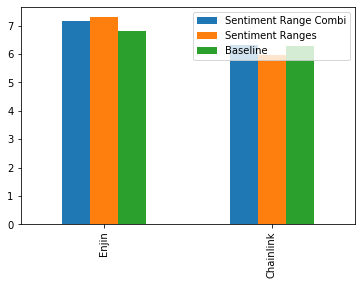

In [27]:
eval_sentiment_range_combi_baseline.loc['MAPE USD', (slice(None), ['Enjin', 'Chainlink'])] \
                                       .unstack(level=0).plot(kind='bar')

## Santiment Blockchain Activity Data via sanpy:


Santiment provides a Python library "sanpy" for accessing blockchain activity data for hundreds of altcoins. Their API allows users to access real time or historical data up to 3 months back.

Time frame needed for my work is a bit more than 1 year back. So, I had to set up an api key and change to a ”Premium Subscription Plan” which also gave me access to all premium metrics.

In [28]:
# Define a list of Santiment metrics to retrieve
metrics = ['daily_active_addresses',
            'network_growth',
            'age_destroyed',
            'average_token_age_consumed_in_days',
            'transaction_volume',
            'velocity',
            'circulation_1d',
            'daily_active_deposits',
            'github_activity',
            'exchange_funds_flow'
        ]

# Initialize SantimentAltcoinData objects for all altcoins with start & end date
sad_o1 = SAD(project='omisego', start_date="2019-01-01", end_date="2020-01-18")
sad_e1 = SAD(project='enjin-coin', start_date="2019-01-01", end_date="2020-01-18")
sad_c1 = SAD(project='chainlink', start_date="2019-01-01", end_date="2020-01-18")
# Retrieve time series all metrics in the list, and concatenate them into a dataframe
sad_o1.get_metrics(metrics)
sad_e1.get_metrics(metrics)
sad_c1.get_metrics(metrics)
# Concatenate priceUsd & price Btc to the dataframe
sad_o1.concat_price_to_df()
sad_e1.concat_price_to_df()
sad_c1.concat_price_to_df()

Show the first 5 rows of Chainlink's dataset with blockchain activity features

In [29]:
# Show Chainlink's dataframe
sad_c1.df.head()

,daily_active_addresses,network_growth,age_destroyed,average_token_age_consumed_in_days,transaction_volume,velocity,circulation_1d,daily_active_deposits,github_activity,exchange_funds_flow,priceBtc,priceUsd
datetime,,,,,,,,,,,,
2019-01-01,132.0,55.0,1.240024e+08,71.373484,1.737373e+06,1.263448,1.375104e+06,7.0,0.0,2.741175e+03,0.000078,0.299371
2019-01-02,161.0,46.0,1.887093e+07,18.782738,1.004695e+06,1.516821,6.623688e+05,13.0,21.0,-2.393257e+05,0.000080,0.316489
2019-01-03,324.0,89.0,4.475185e+08,22.984859,1.947014e+07,3.108749,6.263014e+06,35.0,38.0,-4.140549e+05,0.000096,0.366445
2019-01-04,444.0,116.0,7.364449e+08,54.344323,1.355146e+07,2.494980,5.431490e+06,64.0,50.0,1.419252e+06,0.000113,0.437175
2019-01-05,238.0,64.0,9.561996e+07,12.460232,7.674011e+06,1.933282,3.969421e+06,21.0,14.0,5.641666e+05,0.000103,0.395948


Plot Chainlink's Santiment Features to give us an idea how they fluctuate:

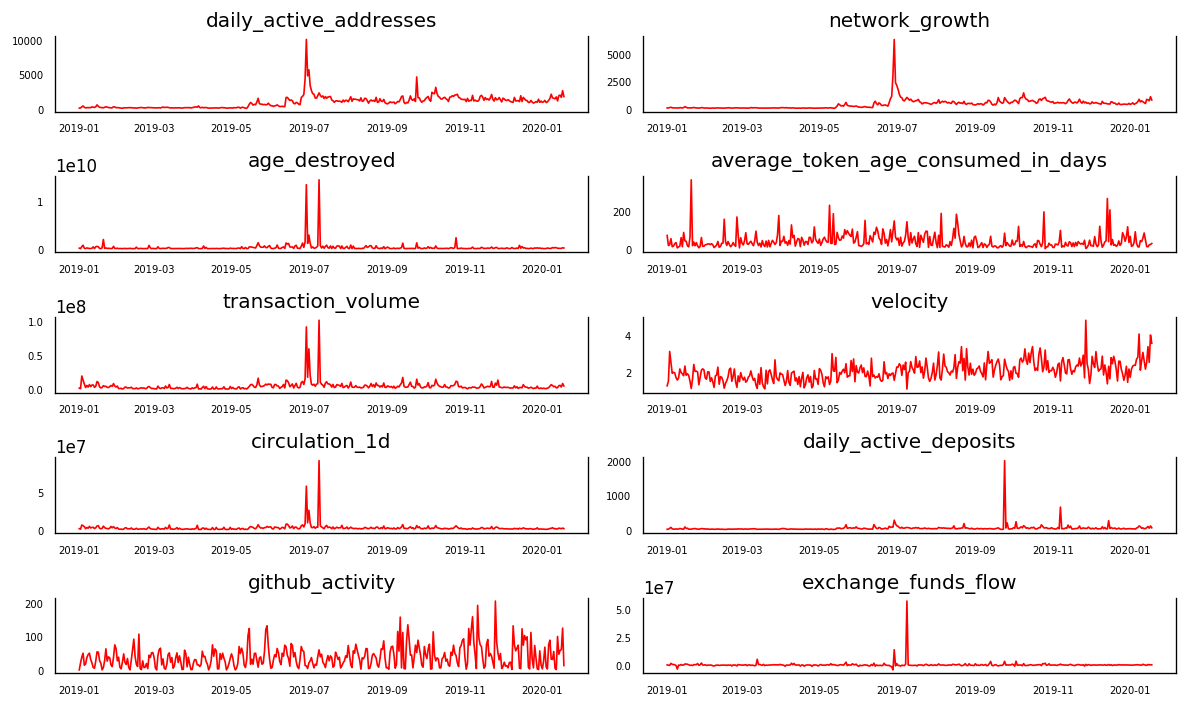

In [30]:
util.plot_features(sad_c1.df)

### Stationarity Check (ADF Test) of Santiment Features
The VAR model requires the time series we want to predict to be stationary. A time series is stationary if the mean and variance does not change over time.

I use the Augmented Dickey-Fuller Test. The function adfuller_test() is written by machinelearningplus.com.

The Augmented Dickey-Fuller function tests the null hypothesis that the time series is non-stationary. If a series is non-stationary, we can make it stationary by differencing the series once and repeat until it becomes stationary.

In [31]:
util.adfuller_test(sad_c1.df['transaction_volume'], signif=0.05, name='transaction_volume')

    Augmented Dickey-Fuller Test on "transaction_volume" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8727
 No. Lags Chosen       = 13
 Critical value 1%     = -3.448
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0486. Rejecting H0.
 => Series is Stationary.


('transaction_volume', 0.0486, True)

After applying the Augmented Dickey-Fuller Test, the p-values for all features of Chainlink shows that the dataset can be seen as stationary:

Chainlink only has the feature "velocity" that was tested as non-stationary.

In [32]:
adf_values = []
for name, column in sad_c1.df.iteritems(): 
    adf_values.append(util.adfuller_test(column, name=column.name, verbose=False))
# Create Dataframe for ADF Test results
adf_c1 = pd.DataFrame(adf_values, columns=['Feature', 'p-value', 'Stationary'])
adf_c1

,Feature,p-value,Stationary
0,daily_active_addresses,0.0001,True
1,network_growth,0.0000,True
2,age_destroyed,0.0314,True
3,average_token_age_consumed_in_days,0.0000,True
4,transaction_volume,0.0486,True
5,velocity,0.2018,False
6,circulation_1d,0.0389,True
7,daily_active_deposits,0.0000,True
8,github_activity,0.0134,True
9,exchange_funds_flow,0.0000,True


We can make the non-stationary series stationary by differencing them. In our case, we can either proceed with the current datasets or difference all the series one time to make all the features stationary. However, if we difference a series, it reduces the length of the series by 1.

Because the time series must have the same length, we would need to difference all the series in the dataframe. Since most of the series are stationary, I decided to not difference at all and use the time series as it is.

### Fit + predict Santiment Dataset

Fit + predict the Santiment datasets for all 11 prediction periods.

Then, save error metrics in a dict to create a dataframe.

In [33]:
# Set Datetime Index frequency="D" to prevent the following warning when doing predictions:
# -> ValueWarning: No frequency information was provided, so inferred frequency D will be used
sad_o1.df.index = pd.DatetimeIndex(sad_o1.df.index.values,
                                freq=sad_o1.df.index.inferred_freq)
sad_e1.df.index = pd.DatetimeIndex(sad_e1.df.index.values,
                                freq=sad_e1.df.index.inferred_freq)
sad_c1.df.index = pd.DatetimeIndex(sad_c1.df.index.values,
                                freq=sad_c1.df.index.inferred_freq)

# Fit + predict for all altcoin's datasets
sad_o1_pred, sad_o1_plots = util.predict_multi_periods(df=sad_o1.df, dates=pred_dates, predictor=AltcoinPredictor)
sad_e1_pred, sad_e1_plots = util.predict_multi_periods(df=sad_e1.df, dates=pred_dates, predictor=AltcoinPredictor)
sad_c1_pred, sad_c1_plots = util.predict_multi_periods(df=sad_c1.df, dates=pred_dates, predictor=AltcoinPredictor)

### Evaluation Metrics (Santiment Features vs. Twitter Baseline)

In [34]:
# Create Dataframe for Error Metrics
sad_o1_pred_df = pd.DataFrame(sad_o1_pred, index=pred_dates)
sad_e1_pred_df = pd.DataFrame(sad_e1_pred, index=pred_dates)
sad_c1_pred_df = pd.DataFrame(sad_c1_pred, index=pred_dates)
# Evaluation Metric with Santiment Dataset
sad1_eval = pd.DataFrame([sad_o1_pred_df.mean(), sad_e1_pred_df.mean(), sad_c1_pred_df.mean()],
                        index=['OmiseGo', 'Enjin', 'Chainlink']).T
san_baseline = pd.concat([sad1_eval, baseline_eval], axis=1, keys=['Santiment Baseline', 'Twitter Baseline']).apply(lambda x: round(x, 3))
san_baseline

Santiment Baseline                   Twitter Baseline  \
                                OmiseGo   Enjin Chainlink          OmiseGo   
nRMSE USD                         0.079   0.072     0.069            0.074   
MAPE USD                          6.824   5.858     5.746            6.420   
nRMSE BTC                         0.063   0.122     0.045            0.056   
MAPE BTC                          5.528  10.849     3.561            4.820   
USD Movement correct              0.364   0.545     0.636            0.364   
BTC Movement correct              0.364   0.727     0.545            0.364   

                                       
                      Enjin Chainlink  
nRMSE USD             0.079     0.074  
MAPE USD              6.817     6.272  
nRMSE BTC             0.101     0.049  
MAPE BTC              9.030     4.015  
USD Movement correct  0.364     0.455  
BTC Movement correct  0.636     0.545

### Plot Evaluation (Santiment Features vs. Twitter Baseline)

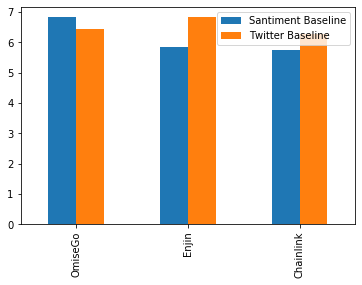

In [35]:
san_baseline.loc['MAPE USD'].unstack(level=0).plot(kind='bar')

### To-Add (Granger's Causality Test)